# Exploring Relationships Between SAT Results and Demographic Factors in NYC High School

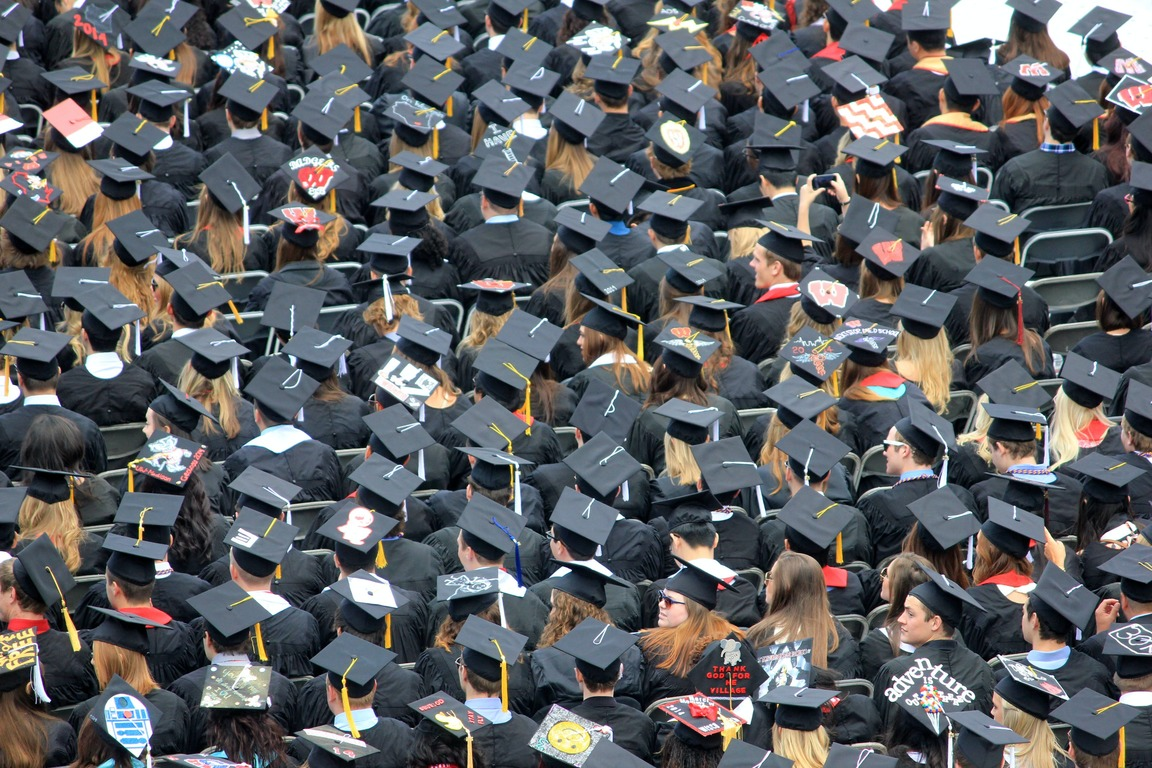

## Introduction
In this project, we are going to analyze relationships between SAT scores and demographic factors in New York City public schools. The [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college.  It has three sections, each of which is worth a maximum of 800 points. High average SAT scores are usually indicative of a good school and overall school district quality.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) by high school, along with additional demographic datasets. 

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) – SAT scores for each high school in NYC.
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) – attendance information for each school in NYC.
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) – information on class size for each school.
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) – Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject).
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) – the percentage of graduated students and other outcome information.
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) – demographic information for each school.
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) – surveys of parents, teachers, and students at each school.

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain categories of students consistently perform better on the SAT, we would have some evidence that the SAT is unfair.
### Summary of Results
We found out that some factors (safety and respect scores, total enrollment, female percentage, White and Asian race percentages, AP test takers percentage, class size) show a positive correlation with SAT scores, while some others (the percentages of English learners, males, Black and Hispanic races, free and reduced lunches as an indicator of a student's family income) – a negative one. District 22 of Brooklyn is characterized by the highest scores of both SAT and safety & respect. In the survey, parents tend to give the highest scores, while students – the lowest. 
## Data Reading

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.basemap import Basemap

# Creating a list of all csv files
data_files = ['ap_2010.csv', 'class_size.csv', 'demographics.csv',
              'graduation.csv', 'hs_directory.csv', 'sat_results.csv']

# Reading all the datasets from the list and adding them to the dictionary
data = {}
for f in data_files:
    d = pd.read_csv('schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d

Two other datasets (surveys) are tab-delimited and encoded with Windows-1252 encoding, so we'll need to specify it when reading this data. Next, we'll combine the survey datasets into a single dataframe:

In [2]:
# Reading and combining the survey datasets
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

## Data Cleaning
We'll start with renaming the `dbn` column (which is a unique ID for each school) of the survey dataframe to `DBN` to make the column name consistent with the other datasets. Then, we'll filter the data to leave only relevant columns, which we can figure out from a data dictionary at the [original data download location](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8):

In [3]:
# Renaming the column
survey['DBN'] = survey['dbn']

# Creating a list of relevant columns
survey_fields = [
    'DBN',            # School identification code (district borough number)
    'rr_s',           # Student Response Rate
    'rr_t',           # Teacher Response Rate
    'rr_p',           # Parent Response Rate
                 #------------NUMBER OF RESPONDENTS------------
    'N_s',            # students
    'N_t',            # teachers
    'N_p',            # parents
                 #-------------------SCORES--------------------
                 #--------------STUDENT RESPONSES--------------
    'saf_s_11',       # Safety and Respect 
    'com_s_11',       # Communication 
    'eng_s_11',       # Engagement 
    'aca_s_11',       # Academic expectations 
                 #--------------TEACHER RESPONSES--------------
    'saf_t_11',       
    'com_t_11',      
    'eng_t_11',       
    'aca_t_11',       
                 #---------------PARENT RESPONSES--------------
    'saf_p_11',       
    'com_p_11',       
    'eng_p_11',       
    'aca_p_11',       
                 #-----------------TOTAL SCORES----------------    
    'saf_tot_11',     
    'com_tot_11',     
    'eng_tot_11',     
    'aca_tot_11',    
]

# Filtering only relevant columns
survey = survey.loc[:, survey_fields]

# Assigning the dataset to the dictionary
data['survey'] = survey

Now we'll rename the `dbn` column to `DBN` also for the `hs_directory` dataset and add the `DBN` column to the `class_size` dataset. In the last case, it's practically a combination of the `CSD` and `SCHOOL CODE` columns:

In [4]:
# Renaming the column
data['hs_directory']['DBN'] = data['hs_directory']['dbn']
    
# Padding a leading 0 where needed
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(lambda x: str(x).zfill(2))

# Creating the 'DBN' column
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

Let's create a column that totals up the SAT scores for different sections of the exam. Before we do, we have to convert those values to numeric:

In [5]:
# Converting the columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

# Calculating a column with total SAT scores
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

We'll convert to numeric also some columns of the `ap_2010` dataset:

In [6]:
# Converting the columns to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for c in cols:
    data['ap_2010'][c] = pd.to_numeric(data['ap_2010'][c], errors='coerce')

The last step in our data cleaning process will be parsing the latitude and longitude coordinates for each school, using the `Location 1` column of the `hs_directory` dataset:

In [7]:
# Creating functions for parsing the coordinates
def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lat = coords[0].split(',')[0].replace('(', '')
    return lat

def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lon = coords[0].split(',')[1].replace(')', '').strip()
    return lon

# Parsing the coordinates and converting them to numeric
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

## Data Combining
Before combining the datasets, we'll condense some of them so that each value in the `DBN` column is unique:

In [8]:
# Condensing the 'class_size' dataset 
# Filtering only high schools and 'GEN ED' as the most popular program type
class_size = data['class_size']
class_size = class_size[(class_size['GRADE ']=='09-12')
                      & (class_size['PROGRAM TYPE']=='GEN ED')]

# Calculating average class size per school
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)

# Re-assigning the 'class_size' dataset back to the dictionary
data['class_size'] = class_size
#_______________________________________________________________________________________
# Condensing the demographics dataset 
# Filtering the most recent years
data['demographics'] = data['demographics'][data['demographics']['schoolyear']==20112012]
#_______________________________________________________________________________________
# Condensing the graduation dataset 
# Filtering the most recent full cohort
data['graduation'] = data['graduation'][(data['graduation']['Cohort']=='2006') 
                                      & (data['graduation']['Demographic']=='Total Cohort')]

Now, we'll combine all the datasets using the following strategy:

1. Being the `sat_results` dataset our main concern, we'll want to preserve as many rows as possible from it while minimizing null values.

2. While some of the datasets have a lot of missing DBN values, we don't want to lose too many rows (i.e., the data for many high schools) when merging. 

3. Some datasets have DBN values almost identical to those in the `sat_results` dataset. They also have the information we need to keep, and most of our analysis would be impossible if a significant number of rows were missing from those datasets. Therefore, we must avoid missing data in them.

After that, we'll fill missing values:

In [9]:
# Merging datasets
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']
for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')

# Filling missing values
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

Let's add a column to our combined dataset that specifies the school district:

In [10]:
combined['school_dist'] = combined['DBN'].apply(lambda x: x[0:2])

## Finding Correlations
Here we'll take a look at how the `sat_score` column correlates with the others:

In [11]:
correlations = combined.corr()['sat_score']
print(correlations[:35])
print(correlations[35:])

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Unsurprisingly, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` are strongly correlated with `sat_score`.

We can also make some other observations:

- `total_enrollment` and its proxies (`total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`) have a strong positive correlation with `sat_score`. This seems counterintuitive: we'd expect smaller schools where students receive more attention having higher scores. 
- The percentage of females correlates positively with SAT scores, whereas that of males – negatively. This could indicate that women do better on the SAT than men.
- Teacher and student ratings of school safety and respect (`saf_t_11` and `saf_s_11`) correlate with SAT scores.
- Student ratings of school academic standards (`aca_s_11`) correlate with SAT scores, but this doesn't hold for ratings from teachers and parents.
- There is significant racial inequality in SAT scores.
- The percentage of English language learners at the school (`ell_percent`) has a strong negative correlation with SAT scores.

## Plotting Survey Correlations
Let's now visualize how the survey columns of our combined dataset correlate with SAT scores. Before, we've created a list of those columns called `survey_fields`:

In [12]:
print(survey_fields)

['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


First, we'll remove DBN since it's a unique identifier, not a useful numerical value for correlation:

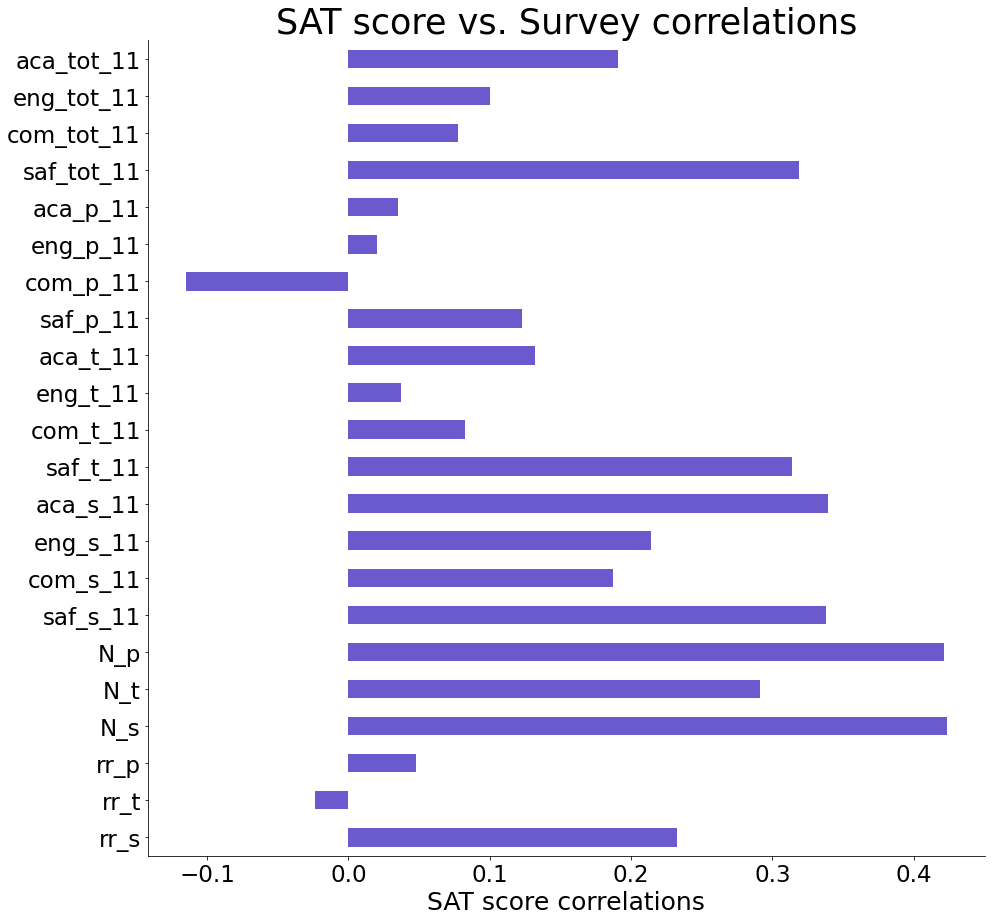

In [13]:
survey_fields.remove('DBN')

# Defining a function for creating bar plots
def create_bar_plot_vs_sat(figsize, categories, title):
    fig, ax = plt.subplots(figsize=figsize)
    combined.corr()['sat_score'][categories].plot.barh(color='slateblue', fontsize=23)
    plt.title(title, fontsize=35)
    plt.xlabel('SAT score correlations', fontsize=25)
    sns.despine()
    return ''

# Plotting the correlations    
print(create_bar_plot_vs_sat(figsize=(15,15), categories=survey_fields,
                             title='SAT score vs. Survey correlations'))

From this plot, we can confirm once again some of our previous observations:

- Numbers of students, parents, and teachers (`N_s`, `N_p`, `N_t`) have a strong positive correlation with SAT scores.
- Teacher and student ratings of school safety and respect correlate with SAT scores, which looks reasonable.
- Student academic expectations scores correlate with SAT scores, but this doesn't hold for those from teachers and parents.

In addition, this plot allows us to discern some new patterns:

- Only 2 survey fields show a negative correlation with SAT scores. It looks logical: things like safety, respect, communication, academic standards, and engagement are indeed positive, and are supposed to be beneficial for learning outcomes. 
- Scores from parents mostly show poor correlation with SAT scores, up to even be negative in case of communication score. This can probably mean their lack of involvement in those questions and/or misunderstanding of some concepts (for example, considering communication as a distracting factor for the learning process).
- The student response rate shows a rather strong positive correlation with SAT scores. It seems that students who demonstrate high learning results tend also to be more active socially (participating in such surveys).

## Exploring Safety & Respect and SAT Scores

Let's investigate in more detail the correlation of how teachers and students perceive safety and respect at school with SAT scores:

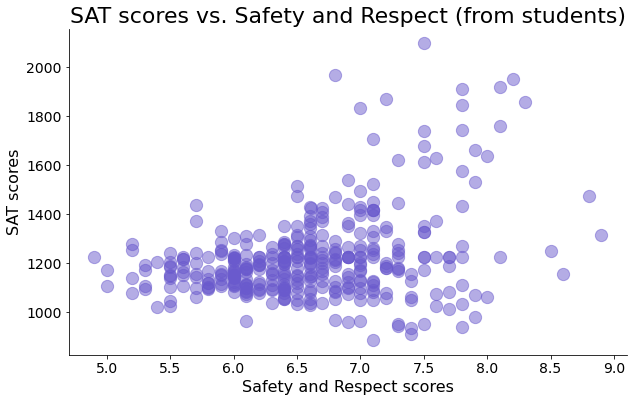

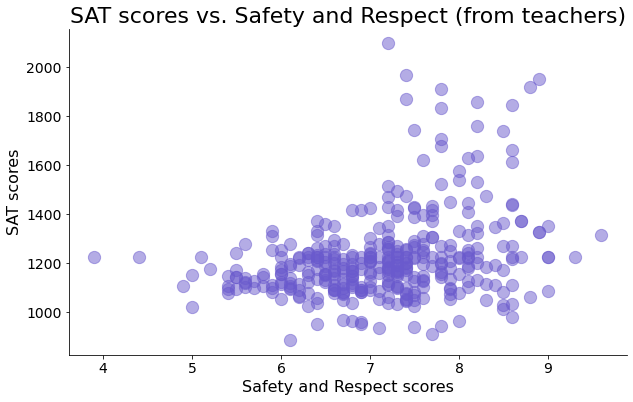

In [14]:
# Defining a function for creating scatter plots
def create_scatter_plot_vs_sat(x, title, xlabel):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(combined[x], combined['sat_score'],
               color='slateblue', s=150, alpha=0.5)    
    plt.title(title, fontsize=22)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('SAT scores', fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    sns.despine()
    return ''
 
# Plotting 'sat_score' vs. 'saf_s_11'
print(create_scatter_plot_vs_sat(x='saf_s_11',
                                 title='SAT scores vs. Safety and Respect (from students)',
                                 xlabel='Safety and Respect scores'))
print('\n')

# Plotting 'sat_score' vs. 'saf_t_11'
print(create_scatter_plot_vs_sat(x='saf_t_11',
                                 title='SAT scores vs. Safety and Respect (from teachers)',
                                 xlabel='Safety and Respect scores'))

We can clearly see that a positive correlation between safety and respect perception by both students and teachers with SAT scores really exists, even if it isn't so strong. Also, all the schools with "anomalously" high values of SAT scores are related exactly to those with rather high safety and respect scores (starting from around 6.7 according to students and from 7 according to teachers). However, the highest safety and respect scores on both plots are not related to the schools with the highest SAT scores. 
### Safety & Respect Scores by Borough and District
It would be interesting to take a look at safety and respect scores by borough:

In [15]:
# Sorting safety and respect scores by borough from the student survey 
combined.groupby('boro').agg(np.mean)['saf_s_11'].sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

In [16]:
# Sorting safety and respect scores by borough from the teacher survey 
combined.groupby('boro').agg(np.mean)['saf_t_11'].sort_values(ascending=False)

boro
Queens           7.365625
Manhattan        7.287778
Staten Island    7.210000
Bronx            7.026882
Brooklyn         6.985849
Name: saf_t_11, dtype: float64

We can deduce that in general, according to both students and teachers, the schools in Manhattan and Queens have the highest safety and respect scores, while those in Brooklyn – the lowest.

Let's look at these scores in more detail, mapping them by district. For this purpose, we'll use the `saf_tot_11` column:

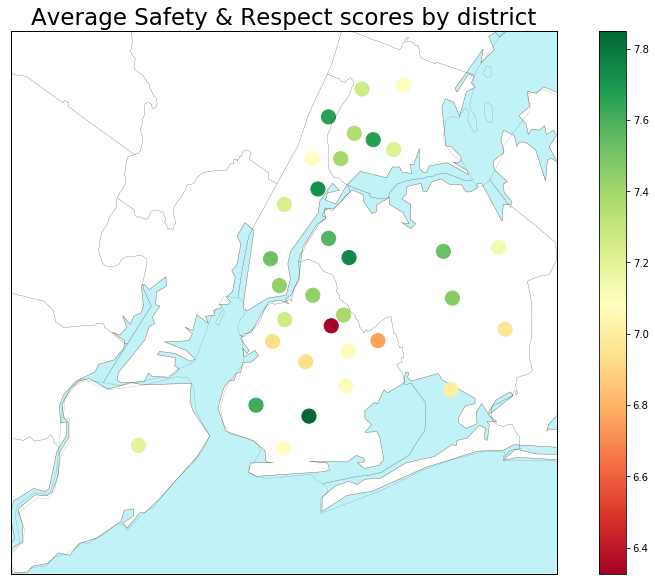

In [17]:
# Grouping the dataframe by district
districts = combined.groupby('school_dist').mean()
districts.reset_index(inplace=True)

# Creating a map
plt.figure(figsize=(15, 10))
m = Basemap(projection='merc',
            llcrnrlat=40.496044,
            urcrnrlat=40.915256,
            llcrnrlon=-74.255735,
            urcrnrlon=-73.700272,
            resolution='h')
m.drawmapboundary(fill_color='#c1f2f8')
m.drawcoastlines(color='#6D5F47', linewidth=0.4)
m.drawrivers(color='#6D5F47', linewidth=0.4)
m.fillcontinents(color='white')
m.drawcounties(color='black',zorder=999)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

# Plotting districts
m.scatter(longitudes, latitudes,
          s=200, zorder=2, latlon=True,
          c=districts['saf_tot_11'],
          cmap='RdYlGn')               # A traffic-light template, with green – the safest, 
                                       # red – the least safe
plt.colorbar()
plt.title('Average Safety & Respect scores by district', fontsize=23)
plt.show()

It seems that our previous conclusions were actually biased: there is only one district with a very low safety and respect score, located in Brooklyn (where we see also the district with the highest score), and this value definitely influences the whole distribution of safety and respect scores, making it heavily left-skewed.
### SAT Scores by Borough and District
Let's do the same analysis for SAT scores:

boro
Staten Island    1382.500000
Queens           1286.753032
Manhattan        1278.331410
Brooklyn         1181.364461
Bronx            1157.598203
Name: sat_score, dtype: float64


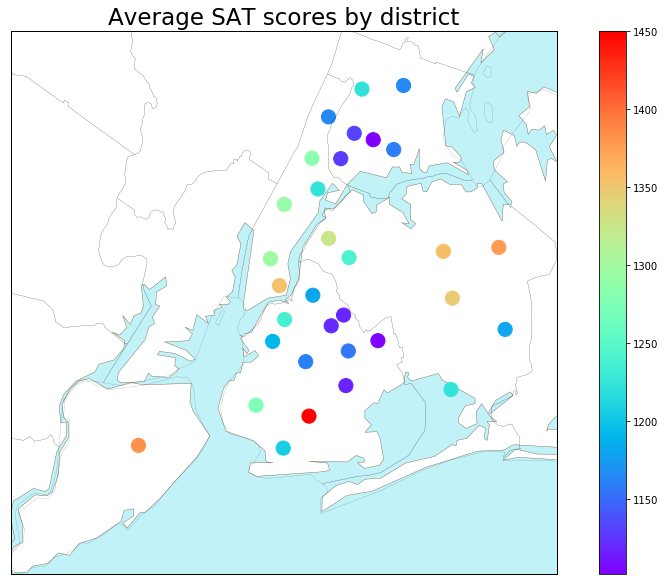

In [18]:
# Sorting SAT scores by borough
sat_by_borough = combined.groupby('boro').agg(np.mean)['sat_score'].sort_values(ascending=False)
print(sat_by_borough)

# Creating a map
plt.figure(figsize=(15, 10))
m = Basemap(projection='merc',
            llcrnrlat=40.496044,
            urcrnrlat=40.915256,
            llcrnrlon=-74.255735,
            urcrnrlon=-73.700272,
            resolution='h')
m.drawmapboundary(fill_color='#c1f2f8')
m.drawcoastlines(color='#6D5F47', linewidth=0.4)
m.drawrivers(color='#6D5F47', linewidth=0.4)
m.fillcontinents(color='white')
m.drawcounties(color='black',zorder=999)

# Plotting districts
m.scatter(longitudes, latitudes,
          s=200, zorder=2, latlon=True,
          c=districts['sat_score'],
          cmap='rainbow')         # A rainbow template, with red – the highest SAT score, 
                                  # violet – the lowest
plt.colorbar()
plt.title('Average SAT scores by district', fontsize=23)
plt.show()

If to look only at the statistics by borough, it looks like the highest SAT scores are related to Staten Island. However, the map shows that this borough is actually represented by only one district, hence it's definitely undersampled. In Brooklyn and Bronx, we have many districts characterized by very low SAT scores. On the other hand, in Brooklyn, there is a district with the highest SAT score, and it's the same district that had also the highest safety and respect score on the previous map. Let's find the number of this district:

In [19]:
districts[districts['sat_score']==districts['sat_score'].max()]['school_dist'].squeeze()

'22'

Hence, District 22, located in Brooklyn, has the highest safety & respect and SAT scores.
## Exploring Total Enrollment and SAT Scores
When looking for correlations, we noticed that the total enrollment highly correlates with SAT scores. Let's take a closer look at their relationships:

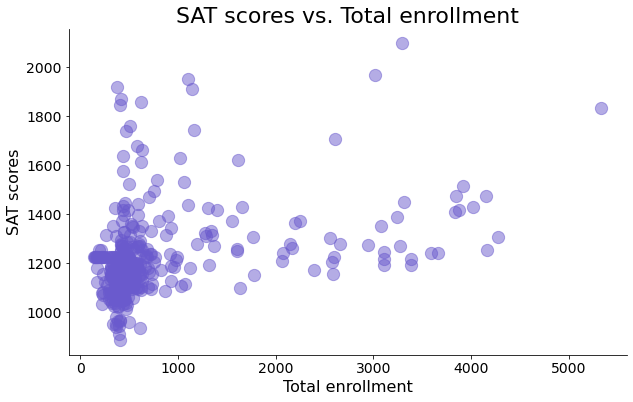

In [20]:
# Plotting 'sat_score' vs. 'total_enrollment'
print(create_scatter_plot_vs_sat(x='total_enrollment',
                                 title='SAT scores vs. Total enrollment',
                                 xlabel='Total enrollment'))

It looks like this correlation really exists, even if not that strong. 

We see that the majority of schools have total enrollment less than 1000 students, so it would be interesting to zoom in this range:

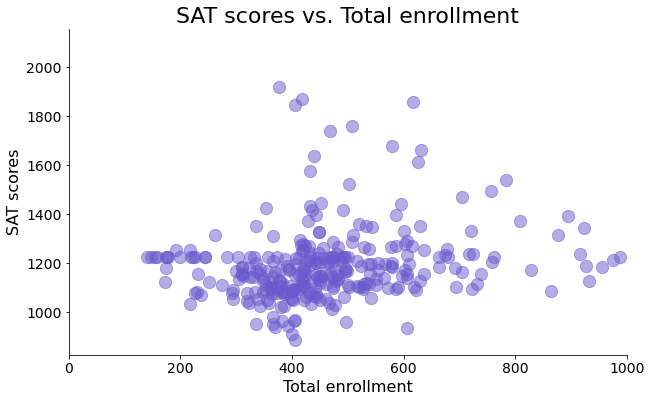

In [21]:
# Plotting 'sat_score' vs. 'total_enrollment'
print(create_scatter_plot_vs_sat(x='total_enrollment',
                                 title='SAT scores vs. Total enrollment',
                                 xlabel='Total enrollment'))
plt.xlim(0, 1000)
plt.show()

Hence, for the schools with a total enrollment less than 1000 students (that is, for the majority of schools) the correlation with SAT scores is even poorer than the global trend.
## Exploring Races and SAT Scores
Next, we are going to plot correlations of percentages of different races  vs. SAT scores, to determine whether there are any racial differences in SAT performance:

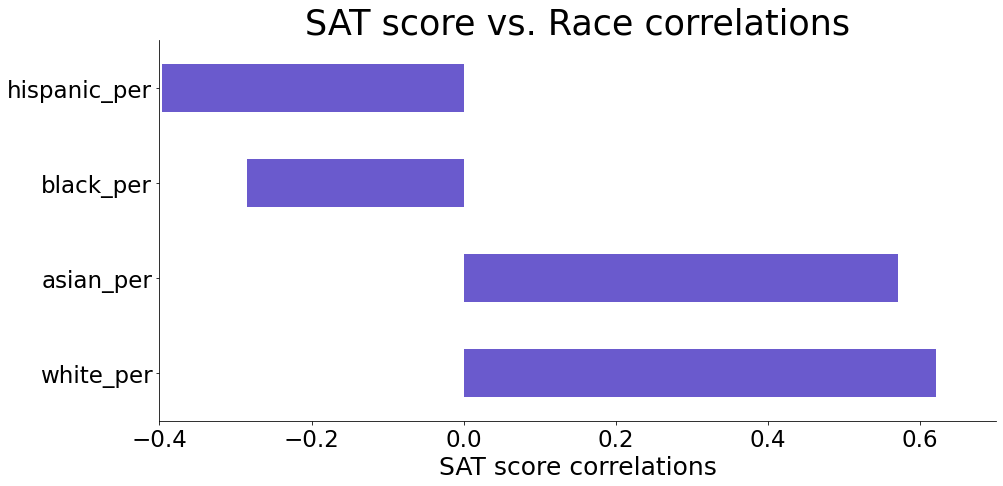

In [22]:
# Creating a list of columns with races
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

# Plotting SAT score vs. race correlations
print(create_bar_plot_vs_sat(figsize=(15,7), categories=races,
                             title='SAT score vs. Race correlations'))
plt.xlim(-0.4, 0.7)
plt.show()

From these 4 races, White and Asian show a strong positive correlation with SAT scores, with the White slightly dominating, while Black and Hispanic – negative correlation, especially strong for the last one.

Let's take a closer look at the negative correlation for the Hispanic race:

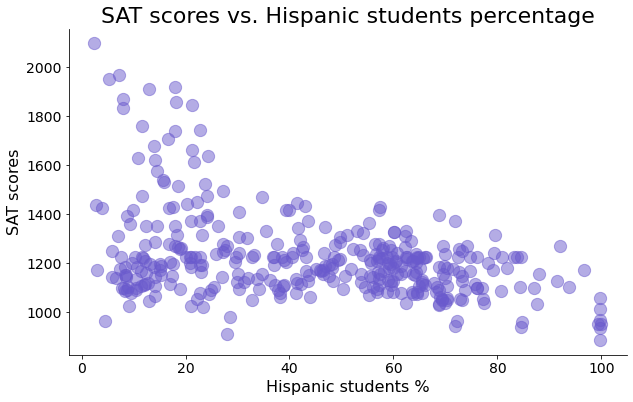

In [23]:
# Plotting 'sat_score' vs. 'hispanic_per'
print(create_scatter_plot_vs_sat(x='hispanic_per',
                                 title='SAT scores vs. Hispanic students percentage',
                                 xlabel='Hispanic students %'))

From this plot, we can confirm a strong negative correlation between Hispanic student percentage and SAT scores. For all the schools where this percentage is higher than 25%, the maximum SAT score is never higher than 1500. And as soon as this percentage decreases from 25%, the number of schools with high SAT scores (as well as SAT scores themselves) drastically increases.

Let's find the schools with more than 95% of Hispanic people:

In [24]:
combined[combined['hispanic_per']>95][['school_name', 'sat_score']]

,school_name,sat_score
44,Manhattan Bridges High School,1058.0
82,Washington Heights Expeditionary Learning School,1174.0
89,Gregorio Luperon High School for Science and M...,1014.0
125,Academy for Language and Technology,951.0
141,International School for Liberal Arts,934.0
176,Pan American International High School at Monroe,970.0
253,Multicultural High School,887.0
286,Pan American International High School,951.0


Searching these schools on Google, we discovered that all of them are specialized in teaching immigrants recently arrived from Spanish-speaking countries, who may not be well-prepared for high school. Among these people, there are many unaccompanied minors and students with limited or interrupted formal education in their countries, having trouble reading in Spanish as well as English. Many of these students are older than traditional high school students and must leave school to support their families. From this context, it's not surprising that these schools demonstrate low SAT results.

Now let's turn our attention to the schools with less than 10% of Hispanic students and an average SAT score greater than 1800:

In [25]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)][['school_name', 'sat_score']]

,school_name,sat_score
37,Stuyvesant High School,2096.0
151,Bronx High School of Science,1969.0
187,Brooklyn Technical High School,1833.0
327,Queens High School for the Sciences at York Co...,1868.0
356,Staten Island Technical High School,1953.0


Google research showed that all of them are prestigious magnet high schools 
(which in the U.S. education system means public schools with specialized courses or curricula), specialized in technology and science, having very strict admission tests and accepting only city residents. It looks now quite explainable that, first, there are few immigrants and, second, that average SAT scores are very high there.
## Exploring Genders and SAT Scores
Let's investigate gender differences in SAT scores:

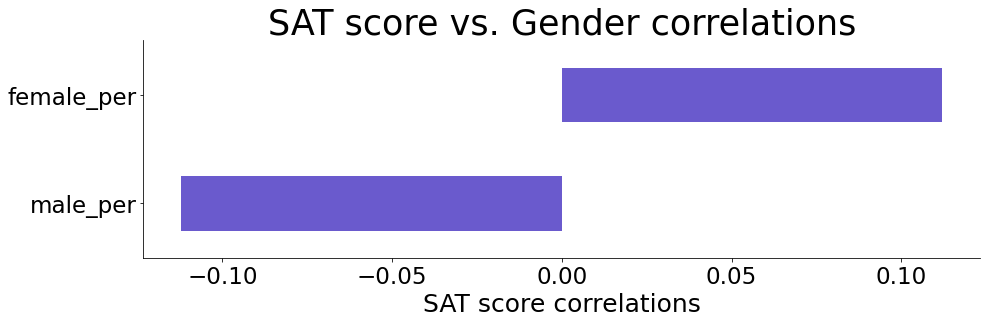

In [26]:
# Creating a list of columns with genders
genders = ['male_per', 'female_per']

# Plotting SAT score vs. gender correlations
print(create_bar_plot_vs_sat(figsize=(15,4), categories=genders,
                             title='SAT score vs. Gender correlations'))

We see that the percentage of females shows a slight positive correlation with SAT scores, and those of males, correspondingly, a slight negative one. It can mean that women do better on the SAT than men. To get more insights, we'll plot the female percentage values and SAT scores:

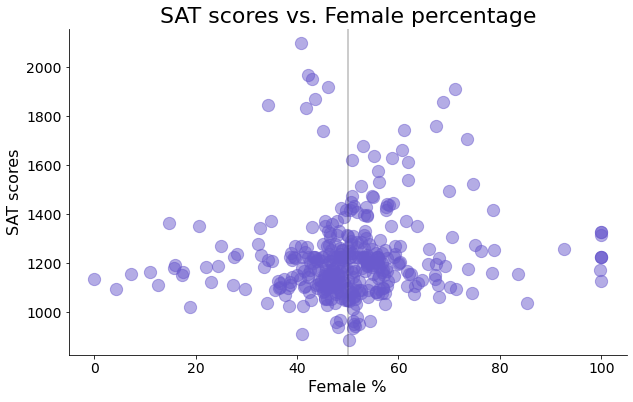

In [27]:
# Plotting 'sat_score' vs. 'female_per'
print(create_scatter_plot_vs_sat(x='female_per',
                                 title='SAT scores vs. Female percentage',
                                 xlabel='Female %'))
plt.axvline(50, color='black', linewidth=0.4)
plt.show()

Naturally, if we plot the percentage of males, the graph would be mirrored with respect to the 50% separation line. 

We can make the following observations here:

- In general, the average results of women on the SAT are indeed slightly higher than those of men.
- The majority of schools have more or less comparable percentages of men and women (with each gender from 40 to 60%).
- There are around 6 schools with only female students and 1 school with only male ones. For both of these groups, the SAT scores are just normal, without any anomalous values.
- A cluster of 6 schools with high SAT scores up to 2100 is detected to the left of the separation line, with the number of women from 35 to 50%.
- Another group of high SAT scores, the bigger and more spread-out one, is located immediately to the right of the separation line, with the number of women from 50 to 80%.

It would be curious to have a look at the schools from the last 2 clusters:

In [28]:
combined[(combined['female_per']<50)&(combined['sat_score']>1700)][['school_name', 'sat_score', 'female_per']]

,school_name,sat_score,female_per
37,Stuyvesant High School,2096.0,40.7
79,"High School for Mathematics, Science and Engin...",1847.0,34.2
151,Bronx High School of Science,1969.0,42.2
155,High School of American Studies at Lehman College,1920.0,46.2
187,Brooklyn Technical High School,1833.0,41.7
198,"Brooklyn Latin School, The",1740.0,45.1
327,Queens High School for the Sciences at York Co...,1868.0,43.5
356,Staten Island Technical High School,1953.0,43.0


Here we recognize the same elite high schools, specialized in technology and science, which we've already seen before. It's logical that average SAT scores in these schools are so high. In addition, it seems reasonable that the gender gap for these schools, despite being present (taking also into account that science and technology generally attract more men than women), is not that significant, with the minimum percentage of women around 35%. Most probably, this can be conditioned by gender policy applied in such schools.

Let's now find out the schools from the second cluster of high SAT scores. We are especially interested in the uppermost five schools of this cloud, with the number of women greater than 60% and average SAT scores greater than 1700: 

In [29]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)][['school_name', 'sat_score', 'female_per']]

,school_name,sat_score,female_per
5,Bard High School Early College,1856.0,68.7
26,Eleanor Roosevelt High School,1758.0,67.5
60,Beacon High School,1744.0,61.0
61,Fiorello H. LaGuardia High School of Music & A...,1707.0,73.6
302,Townsend Harris High School,1910.0,71.1


Google research showed that those are schools with high educational standards, intense curricula, and strict admission requirements. They are mostly specialized in languages, history, social sciences, literature, arts, and music. The highest percentage of women is related to Fiorello H. LaGuardia High School of Music & Art and Performing Arts, which is, as its name suggests, specialized predominantly in different arts.
## Exploring English Leaners Percentage and SAT Scores
Now we'll take a look at the relationship between English learners percentage and SAT scores, since earlier we've noticed a strong negative correlation between them:

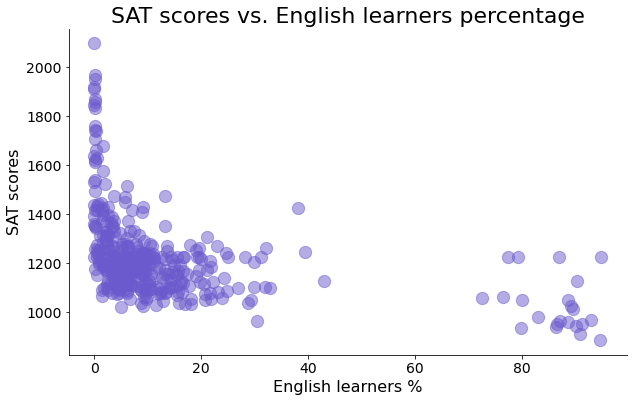

In [30]:
# Plotting 'sat_score' vs. 'ell_percent'
print(create_scatter_plot_vs_sat(x='ell_percent', 
                                 title='SAT scores vs. English learners percentage',
                                 xlabel='English learners %'))

We can notice several things here: 
- A strong negative correlation really exists in this case.
- There are some schools with a very low percentage of English learners (less than 1%) and very high SAT scores – presumably, the elite schools for city residents which we've seen while analyzing race diversity.
- There is a big gap on the plot, with no schools with the English learners' percentage between 50 and 70%. 
- There are schools with more than 70% of English learners and rather low SAT scores. Obviously, those are the schools for the immigrants, who have an additional challenge of learning English, apart from following the main curriculum. Having difficulties with English and, most probably, with the adaptation in a new country, they have also difficulties with the program itself, which results in low SAT scores.
- One school stands out of the trend, having around 40% of English learners and a relatively high SAT score. Let's find its name:

In [31]:
combined[(combined['ell_percent']>35)&(combined['sat_score']>1400)]['school_name'].squeeze()

'High School for Dual Language and Asian Studies'

This resulted to be a dual language English-Mandarin Chinese academically demanding school.
## Exploring AP Scores vs. SAT Scores
In the U.S., high school students can take the Advanced Placement (AP) exam in a particular subject to earn college credit in that subject.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam:

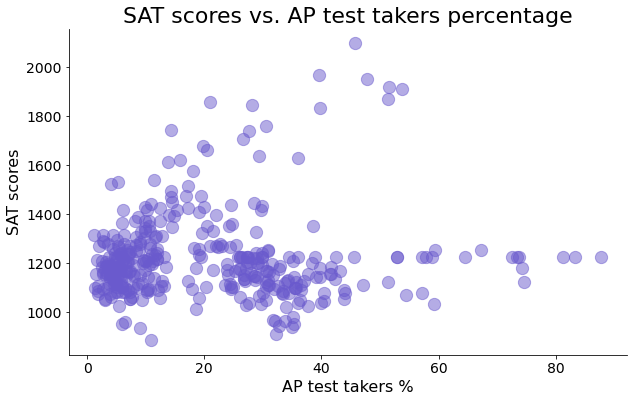

In [32]:
# Calculate the percentage of students in each school who took an AP exam
combined['ap_per'] = combined['AP Test Takers ']*100/combined['total_enrollment']

# Plotting 'sat_score' vs. 'ap_per'
print(create_scatter_plot_vs_sat(x='ap_per',
                                 title='SAT scores vs. AP test takers percentage',
                                 xlabel='AP test takers %'))

On this plot, we can distinguish two clusters:

- The first one (a big cluster on the left side of the plot) demonstrates a strong positive correlation.
- The second big cluster doesn't show any correlation at all, even though here we can see rather high percentages of AP test takers up to more than 95%. 

However, there seems to be an issue with the second cluster: many of the values of AP test takers percentage, especially those high, correspond to almost the same value of SAT score, which looks a kind of an average value. One possible explanation here is that this is a consequence of filling missing values, which we did at the beginning of the project after combining datasets. To check this assumption, let's re-run those steps for a test dataset (`combined_test`) without filling missing values and then re-create the plot above.

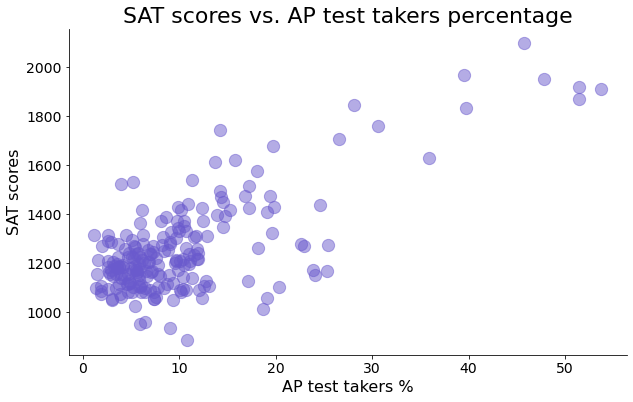

In [33]:
# Re-running the code cell [9] for 'combined_test', without filling missing values
combined_test = data['sat_results']
combined_test = combined_test.merge(data['ap_2010'], on='DBN', how='left')
combined_test = combined_test.merge(data['graduation'], on='DBN', how='left')
to_merge_test = ['class_size', 'demographics', 'survey', 'hs_directory']
for m in to_merge_test:
    combined_test = combined_test.merge(data[m], on='DBN', how='inner')

# Re-running the code cell [31] for 'combined_test'
combined_test['ap_per'] = combined_test['AP Test Takers ']*100/combined_test['total_enrollment']

# Since the function create_scatter_plot_vs_sat() was adapted for the combined dataset,
# we will not use it here and write instead a full code
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(combined_test['ap_per'], combined_test['sat_score'],
           color='slateblue', s=150, alpha=0.5)
plt.title('SAT scores vs. AP test takers percentage', fontsize=22)
plt.xlabel('AP test takers %', fontsize=16)
plt.ylabel('SAT scores', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
sns.despine()
plt.show()

We've just confirmed that indeed there is **a strong positive correlation between AP test takers percentage and SAT scores**, right as we expected from the beginning. The anomalous cluster that we saw on the first plot was just a consequence of filling missing values, which, evidently, was not a good approach in this case.
## Exploring Class Size and SAT Scores
Let's now explore the relationship between average class sizes and SAT scores. Presumably, the smaller the class is, the more attention is given to each student, so the average SAT score should be higher.

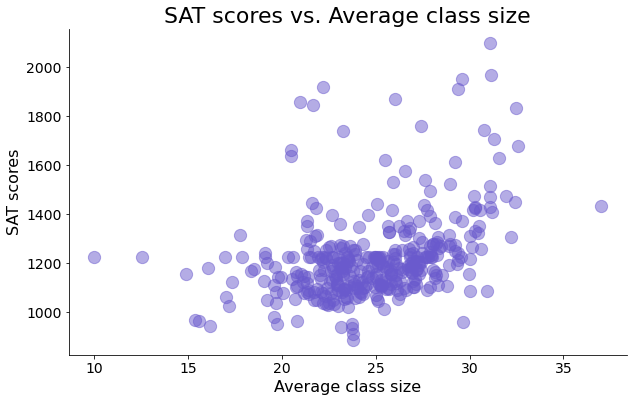

In [34]:
# Plotting 'sat_score' vs. 'AVERAGE CLASS SIZE'
print(create_scatter_plot_vs_sat(x='AVERAGE CLASS SIZE',
                                 title='SAT scores vs. Average class size',
                                 xlabel='Average class size'))

Surprisingly, we observe a strong positive correlation here. There is also a cluster of schools with very high SAT scores, but even among them we clearly see the same trend.
## Exploring Free and Reduced Lunch and SAT Scores
To finish with the correlations of SAT scores with the other demographic factors, let's investigate their relationship with `frl_percent` – free and reduced lunch percentage. It can seem not so straightforward, but this factor serves as an indicator of the income level of a student's family, since free or reduced lunches are, most probably, offered only to the students from low-income families. Earlier we noted that this factor showed a possibility of a strong negative correlation with SAT scores. Let's see it it's confirmed by a scatter plot:

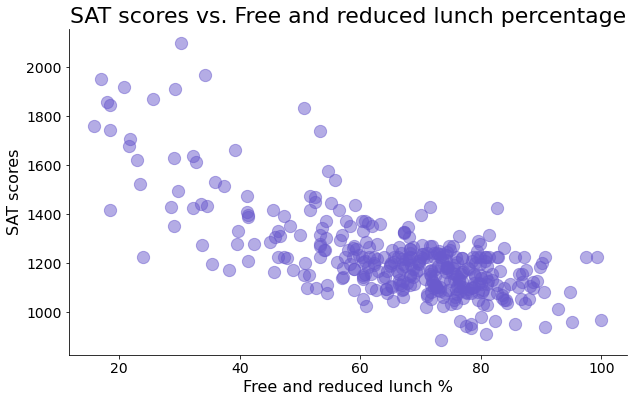

In [35]:
# Plotting 'sat_score' vs. 'frl_percent'
print(create_scatter_plot_vs_sat(x='frl_percent', 
                                 title='SAT scores vs. Free and reduced lunch percentage',
                                 xlabel='Free and reduced lunch %'))

We observe an evident strong negative correlation. It means that the students from subsidized categories (i.e., from poor and low-income families) do worse on the SAT than the students from relatively wealthy families.
## Exploring Parent, Teacher, and Student Responses to Surveys
Now, we'll put apart SAT scores and investigate another aspect of our dataset: the estimations of different types of scores given by parents, teachers, and students. These score types are:

- Safety and Respect Score
- Communication Score
- Engagement Score
- Academic Expectations Score

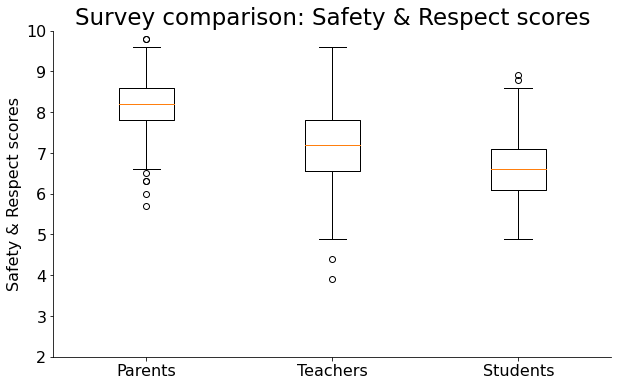

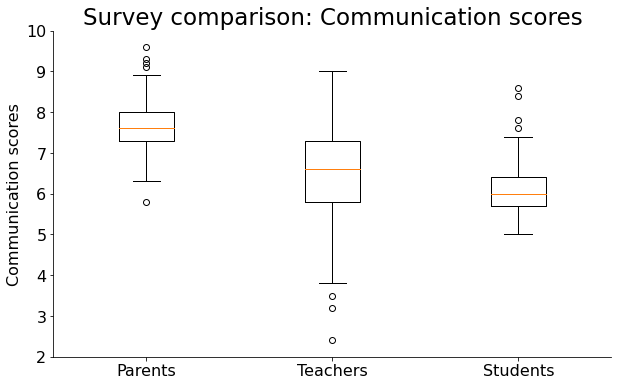

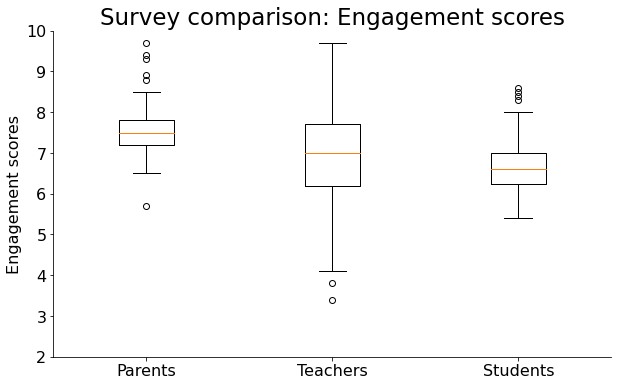

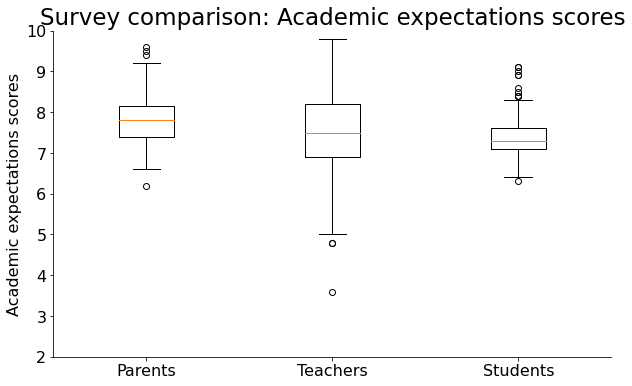

In [36]:
# Creating a list of lists of columns
cols = [['saf_p_11', 'saf_t_11', 'saf_s_11'],
        ['com_p_11', 'com_t_11', 'com_s_11'],
        ['eng_p_11', 'eng_t_11', 'eng_s_11'],
        ['aca_p_11', 'aca_t_11', 'aca_s_11']]

# Creating a list of plot titles
titles = ['Survey comparison: Safety & Respect scores',
          'Survey comparison: Communication scores',
          'Survey comparison: Engagement scores',
          'Survey comparison: Academic expectations scores']

# Creating boxplots for each score type and survey
for i in range(len(cols)):    
    fig = plt.subplots(figsize=(10,6))
    plt.boxplot(combined[cols[i]].values, labels=['Parents', 'Teachers', 'Students'])
    plt.title(titles[i], fontsize=23)
    pattern = titles[i].split(': ')[1]     # Parsing a score type in a plot title 
    plt.ylabel(pattern, size=16)
    plt.tick_params(labelsize=16)
    plt.ylim(2, 10)
    sns.despine()
    plt.show()
    print('\n')

The tendency here is evident: of the 3 groups of survey respondents, parents tend to give the highest score estimations, teachers – somewhere in the middle, students – the lowest. The largest range of scores for each score type is the one from the teacher survey, including also the minimum value of 1.9 for communication score. The biggest difference between median scores is observed for safety and respect score (parent vs. student surveys).
## Conclusion
In this project, we cleaned, combined, visualized, and analyzed data from different datasets, containing information about SAT scores and demographics in NYC public high schools. In particular, we explored relationships between SAT scores and various demographic factors, in order to detect possible biases in the SAT. Additionally, we explored survey responses from parents, teachers, and students of the schools, on how they estimated other factors, possibly influencing learning results. Below are the main findings of our research:
- Positive correlations with SAT scores: safety and respect scores from teachers and students, total enrollment, female percentage, White and Asian race percentages, AP test takers percentage, class size.
- Negative correlations with SAT scores: English learner percentage, male percentage, Black and Hispanic race percentages, free and reduced lunch percentage (as an indicator of a student's family income).
- District 22 of Brooklyn is characterized by the highest scores of both SAT and safety & respect.
- Parents tend to give the highest scores in the survey, while students – the lowest.